In [ ]:
!pip install pdfplumber
!pip install sentence-transformers faiss-cpu
!pip install -U langchain langchain-community sentence-transformers faiss-cpu
!pip install -U langchain langchain-openai
!pip -q install ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.1 MB/s eta 0:00:00


## Подготовка данных

### Извлечение отчистка текста

#### Импорты

In [ ]:
import re
import pdfplumber
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI

Функция загрузки pdf файлов

In [ ]:
def extract_text_from_pdf(pdf_path: Path) -> str:
    text = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text.append(page_text)
    return "\n".join(text)
def extract_pdf_folder(folder: str | Path) -> dict[str, str]:
    folder = Path(folder)
    results = {}

    for pdf_file in folder.glob("*.pdf"):
        print(f"Processing: {pdf_file.name}")
        results[pdf_file.name] = extract_text_from_pdf(pdf_file)

    return results


In [ ]:
texts = extract_pdf_folder('/content/drive/MyDrive/Colab Notebooks/resurse/articles')
print(texts["2020.12.10.419598v2.full.pdf"][:500])

Processing: 2025.10.17.683162v1.full.pdf
Processing: 2023.06.05.543662v1.full.pdf
Processing: 2025.11.07.687156v1.full.pdf
Processing: 2023.04.20.537649v1.full.pdf
Processing: 2025.10.16.682926v1.full.pdf
Processing: 2022.09.16.508278v1.full.pdf
Processing: 2025.01.26.634937v2.full.pdf
Processing: 2025.10.06.680030v1.full.pdf
Processing: 2025.12.09.692941v1.full.pdf
Processing: 2025.12.04.692105v1.full.pdf
Processing: 2025.11.27.690929v1.full.pdf
Processing: 2025.12.03.692255v1.full.pdf
Processing: 2025.11.04.686626v1.full.pdf
Processing: 2025.07.11.659973v2.full.pdf
Processing: 2025.08.18.670945v1.full.pdf
Processing: 2025.06.09.658689v1.full.pdf
Processing: 2025.01.17.633633v1.full.pdf
Processing: 2025.01.10.632400v1.full.pdf
Processing: 2024.08.29.610372v1.full.pdf
Processing: 2024.02.16.578765v1.full.pdf
Processing: 2023.06.15.545187v1.full.pdf
Processing: 2023.03.28.534418v2.full.pdf
Processing: 2020.12.10.419598v2.full.pdf
Processing: 2022.05.14.491965v1.full.pdf
Processing: 2025

Функция очистки текста

In [ ]:
def clean_pdf(text: str) -> str:
  text = re.sub(r'https?://\S+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\n+', '\n', text)
  text = re.sub(r'[ \t]+', ' ', text)
  text = re.sub(r'https?://\S+', '', text)

  return text.strip()


In [ ]:
cleaned_text = {}

for name, text in texts.items():
  cleaned_text[name] = clean_pdf(text)

print(cleaned_text["2020.12.10.419598v2.full.pdf"][:500])

bioRxiv preprint doi this version posted September 6 2022 The copyright holder for this preprint
which was not certified by peer review is the authorfunder All rights reserved No reuse allowed without permission
The Alzheimer risk factor CD2AP causes dysfunction of the brain vascular network
Milène Vandal 1 Adam Institoris 2 Ben Korin 3 Colin Gunn 1 Suzie Lee 1 Jiyeon Lee 3
Philippe Bourassa 45 Ramesh C Mishra 2 Govind Peringod 2 Yulan Jiang 1 Sotaro Hirai 1
Camille Belzil 1 Louise Reveret 45 Cy


Извлечение Abstract, introduce, conclusion

In [ ]:
def extract_between(text: str, start: str, ends: list[str]) -> str | None:
    # Учитываем варианты типа "1 Introduction", "I. INTRODUCTION", "Abstract:" и т.п.
    start_pat = rf"(?:^|\n)\s*(?:\d+\.?\s*|[IVX]+\.\s*)?(?:{start})\s*[:\-]?\s*"
    end_pat = "|".join([rf"(?:\d+\.?\s*|[IVX]+\.\s*)?{e}" for e in ends])
    pattern = rf"(?is){start_pat}(.*?)(?=(?:^|\n)\s*(?:{end_pat})\s*[:\-]?\s*|\Z)"

    m = re.search(pattern, text)
    return m.group(1).strip() if m else None


def extract_aic(text: str) -> dict[str, str]:
    # 1. Пытаемся найти секции по заголовкам
    abstract = extract_between(
        text,
        start=r"abstract",
        ends=[r"keywords?", r"introduction", r"background", r"methods?", r"materials?"]
    )

    introduction = extract_between(
        text,
        start=r"introduction",
        ends=[r"methods?", r"materials?", r"methodology", r"results?", r"experiments?", r"discussion", r"conclusions?"]
    )

    conclusion = extract_between(
        text,
        start=r"conclusions?",
        ends=[r"references", r"bibliography", r"acknowledg(e)?ments", r"appendix", r"supplementary", r"funding"]
    )

    # 2. Fallback: split по Introduction
    m = re.search(r'(?is)\b(?:\d+\.?\s*|[IVX]+\.\s*)?introduction\b', text)

    if m:
        before_intro = text[:m.start()].strip()
        from_intro = text[m.start():].strip()
    else:
        before_intro = text.strip()
        from_intro = ""

    # 3. Применяем правила, которые ТЫ попросил
    if not abstract:
        abstract = before_intro if before_intro else None

    if not conclusion:
        conclusion = from_intro if from_intro else None

    return {
        "abstract": abstract,
        "introduction": introduction,
        "conclusion": conclusion
    }

In [ ]:
sections = extract_aic(cleaned_text[name])
name = "2020.12.10.419598v2.full.pdf"
secs = extract_aic(cleaned_text[name])

print("ABSTRACT:", secs["abstract"][:300])
print("INTRO:", secs["introduction"][:300] if secs["introduction"] else "None")
print("CONCLUSION:", secs["conclusion"][:300])


ABSTRACT: bioRxiv preprint doi this version posted September 6 2022 The copyright holder for this preprint
which was not certified by peer review is the authorfunder All rights reserved No reuse allowed without permission
The Alzheimer risk factor CD2AP causes dysfunction of the brain vascular network
Milène 
INTRO: The brain vasculature is composed of a complex network of vessels with specialized segments
presenting distinct cellular and molecular signatures Schaeffer and Iadecola 2021 Each type
of vessels along the vascular tree plays unique and critical roles in regulating cerebral blood flow
CBF that is ess
CONCLUSION: Introduction
The brain vasculature is composed of a complex network of vessels with specialized segments
presenting distinct cellular and molecular signatures Schaeffer and Iadecola 2021 Each type
of vessels along the vascular tree plays unique and critical roles in regulating cerebral blood flow
CB


Чистим текст при помощи регулярных выражений

In [ ]:
def clean_section(text: str) -> str:
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r"(?i)bioRxiv preprint doi:?.*", " ", text)
    text = re.sub(r"(?i)this version posted.*", " ", text)
    text = re.sub(r"(?i)the copyright holder.*", " ", text)
    text = re.sub(r"(?i)available under a\s*cc-?by.*license\.", " ", text)
    text = re.sub(r'\[(\d+([,\-]\s*\d+)*)\]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


In [ ]:
sections_by_pdf = {}

for name, text in cleaned_text.items():
    secs = extract_aic(text)
    # чистим только найденные секции
    secs = {k: (clean_section(v) if isinstance(v, str) and v.strip() else None) for k, v in secs.items()}
    sections_by_pdf[name] = secs


In [ ]:
name = "2020.12.10.419598v2.full.pdf"

print("ABSTRACT:\n", sections_by_pdf[name]["abstract"][:500] if sections_by_pdf[name]["abstract"] else "NOT FOUND")
print("\nINTRODUCTION:\n", sections_by_pdf[name]["introduction"][:500] if sections_by_pdf[name]["introduction"] else "NOT FOUND")
print("\nCONCLUSION:\n", sections_by_pdf[name]["conclusion"][:500] if sections_by_pdf[name]["conclusion"] else "NOT FOUND")


ABSTRACT:
 which was not certified by peer review is the authorfunder All rights reserved No reuse allowed without permission The Alzheimer risk factor CD2AP causes dysfunction of the brain vascular network Milène Vandal 1 Adam Institoris 2 Ben Korin 3 Colin Gunn 1 Suzie Lee 1 Jiyeon Lee 3 Philippe Bourassa 45 Ramesh C Mishra 2 Govind Peringod 2 Yulan Jiang 1 Sotaro Hirai 1 Camille Belzil 1 Louise Reveret 45 Cyntia Tremblay 5 Mada Hashem 6 Esteban Elias 7 Bill Meilandt 3 Oded Foreman 3 Meron RouseGirma 3 D

INTRODUCTION:
 The brain vasculature is composed of a complex network of vessels with specialized segments presenting distinct cellular and molecular signatures Schaeffer and Iadecola 2021 Each type of vessels along the vascular tree plays unique and critical roles in regulating cerebral blood flow CBF that is essential to supply oxygen and nutrients to the brain Cerebrovascular dysfunction that involves brain endothelial cells BECs and other cell types forming the neurovascular uni

### Exploere data analys (EDA)


#### Выведем первые 5 очищенных статей

In [ ]:
list(cleaned_text.values())[:5]


['bioRxiv preprint doi this version posted October 19 2025 The copyright holder for this preprint\nwhich was not certified by peer review is the authorfunder All rights reserved No reuse allowed without permission\nModeling Alzheimers Disease with APOE4 NeuronGlial Brain Assembloids Reveals\nIGFBPs as Therapeutic Targets\nEliana Sherman12 Kevin Qiu3 Rebecca Roberts4 Lucille Shichman5 Sihan Li1 Huayu Sun6\nLucie Ide1 Allison Tucker127 Seonjoo Lee8 Weronika Gniadzik127 JungBum Shin1 Katia\nSolChurch9 Jaideep Kapur6 Aiying Zhang5 Alev Erisir4 Lulu Jiang127 and For the\nAlzheimers Disease Neuroimaging Initiative\n1Department of Neuroscience 2Center for Brain Immunology and Glia BIG University of\nVirginia School of Medicine Charlottesville VA USA 22908\n3Department of Medicine University of Virginia School of Medicine Charlottesville VA USA\n22903\n4Department of Psychology University of Virginia Charlottesville VA USA 22904\n5School of Data Science University of Virginia Charlottesville V

#### Создаем датафрейм, для более удобного анализа

In [ ]:
df = pd.DataFrame.from_dict(
    sections_by_pdf,
    orient="index"
).reset_index()

df = df.rename(columns={"index": "pdf"})

In [ ]:
df.head()

,pdf,abstract,introduction,conclusion
0,2025.10.17.683162v1.full.pdf,which was not certified by peer review is the ...,Alzheimers disease AD a leading cause of demen...,INTRODUCTION Alzheimers disease AD a leading c...
1,2023.06.05.543662v1.full.pdf,20 Progressive Tau deposition in neurofibrilla...,None,1 Introduction 36 Tau pathology is the hallmar...
2,2025.11.07.687156v1.full.pdf,Lightning has been proposed as a pivotal energ...,Alzheimers disease AD is a progressive neurode...,This study provides compelling evidence that C...
3,2023.04.20.537649v1.full.pdf,The recent massive improvements in transcripto...,Singlecell RNA sequencing scRNAseq generates h...,Singlecell RNA sequencing generates high volum...
4,2025.10.16.682926v1.full.pdf,21 Introduction Alzheimers disease AD is a com...,Alzheimers disease AD is a complex neurodegene...,Indeed the results from some targets imply tha...


По информации о датасете видно что у нас есть 27 статей, 25 из них имеют введение, 26 заключение

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pdf           27 non-null     object
 1   abstract      27 non-null     object
 2   introduction  25 non-null     object
 3   conclusion    26 non-null     object
dtypes: object(4)
memory usage: 996.0+ bytes


In [ ]:
df.isna().mean() * 100

,0
pdf,0.000000
abstract,0.000000
introduction,7.407407
conclusion,3.703704


Длины текстов

In [ ]:
for col in ["abstract", "introduction", "conclusion"]:
    df[f"{col}_len"] = df[col].fillna("").str.len()


In [ ]:
df[[c for c in df.columns if c.endswith("_len")]].describe()


,abstract_len,introduction_len,conclusion_len
count,27.000000,27.000000,27.000000
mean,5005.000000,8000.740741,55624.407407
std,11889.435456,11461.654524,41691.126028
min,232.000000,0.000000,0.000000
25%,1457.500000,2747.500000,11142.500000
50%,1591.000000,4627.000000,63551.000000
75%,2448.000000,6500.500000,81405.500000
max,58778.000000,54714.000000,134455.000000


In [ ]:
df["abstract_dup"] = df["abstract"].duplicated()
df["intro_dup"] = df["introduction"].duplicated()

df[["abstract_dup", "intro_dup"]].sum()


,0
abstract_dup,0
intro_dup,1


Построим график распределения длин статей по abstract, introduction и conclusion

<Axes: >

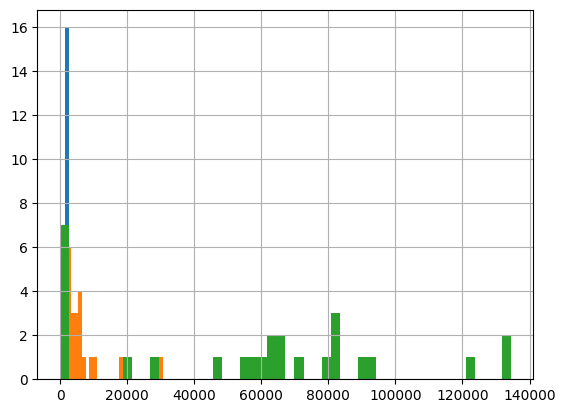

In [ ]:
df["abstract_len"].hist(bins=50)
df["introduction_len"].hist(bins=50)
df["conclusion_len"].hist(bins=50)


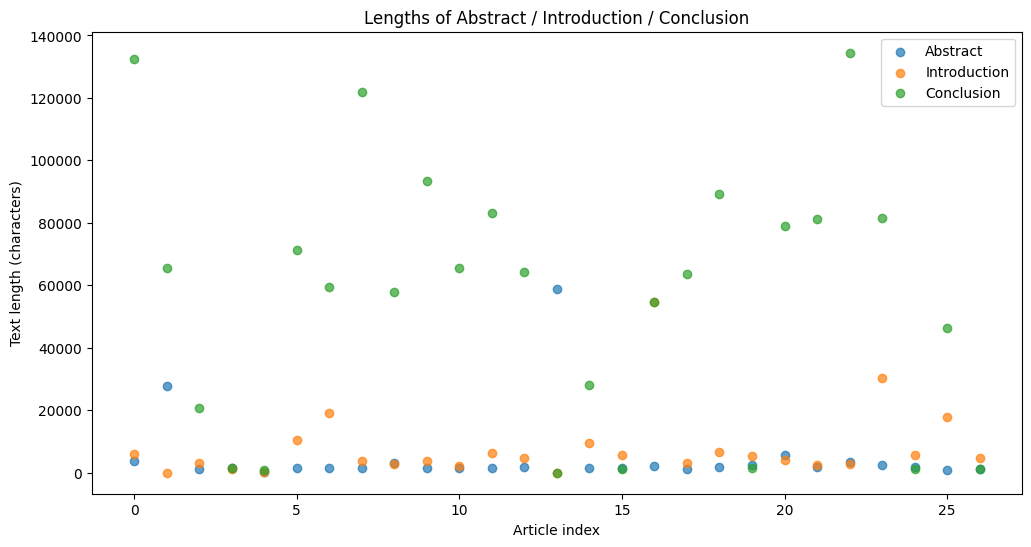

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.scatter(df.index, df["abstract_len"], label="Abstract", alpha=0.7)
plt.scatter(df.index, df["introduction_len"], label="Introduction", alpha=0.7)
plt.scatter(df.index, df["conclusion_len"], label="Conclusion", alpha=0.7)

plt.xlabel("Article index")
plt.ylabel("Text length (characters)")
plt.title("Lengths of Abstract / Introduction / Conclusion")
plt.legend()
plt.show()


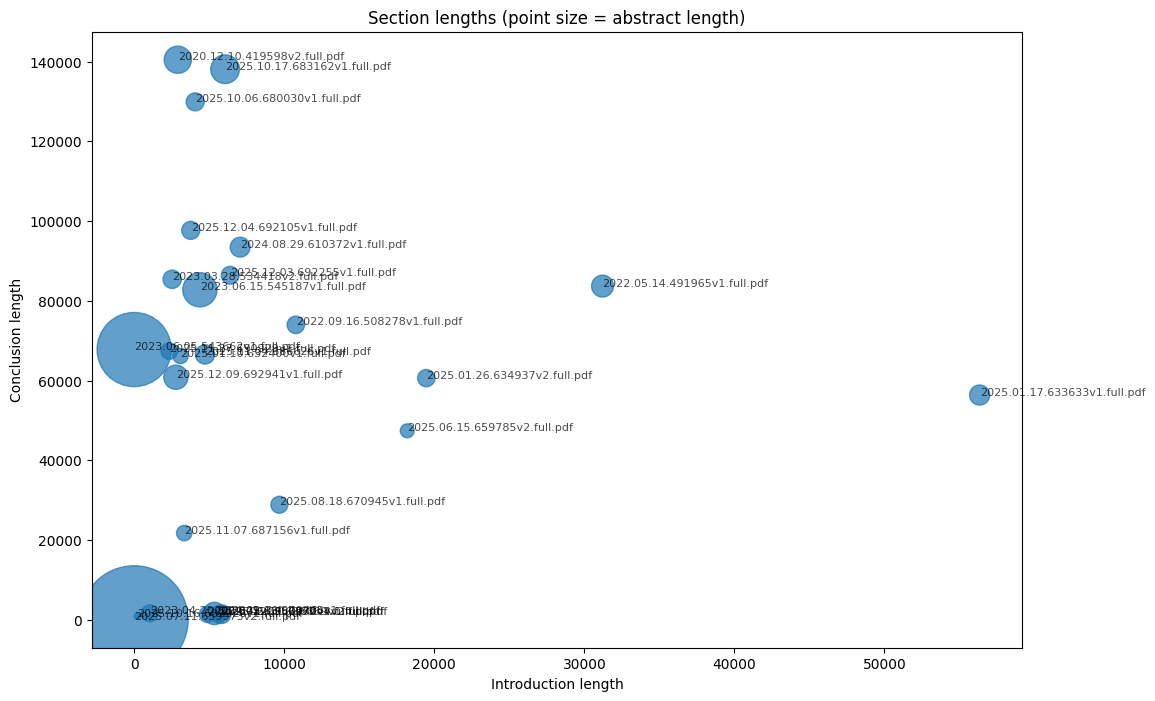

In [ ]:
plt.figure(figsize=(12, 8))

plt.scatter(
    df["introduction_len"],
    df["conclusion_len"],
    s=df["abstract_len"] / 10,  # размер точки = длина abstract
    alpha=0.7
)

for _, row in df.iterrows():
    plt.text(
        row["introduction_len"],
        row["conclusion_len"],
        row["pdf"],
        fontsize=8,
        alpha=0.7
    )

plt.xlabel("Introduction length")
plt.ylabel("Conclusion length")
plt.title("Section lengths (point size = abstract length)")
plt.show()


### Подготовка данных для моделирования

Собираем корпус данных abstract + introduction + conclusion

In [ ]:
import pandas as pd

df["text"] = (
    df["abstract"].fillna("") + "\n\n" +
    df["introduction"].fillna("") + "\n\n" +
    df["conclusion"].fillna("")
).str.strip()

df = df[df["text"].str.len() > 200].reset_index(drop=True)  # убрать совсем пустое/короткое


Чанкинг (разбиение на куски)

In [ ]:
def chunk_text(text: str, chunk_size=1200, overlap=200):
    # chunk_size/overlap — в символах (просто и работает)
    chunks = []
    start = 0
    n = len(text)
    while start < n:
        end = min(start + chunk_size, n)
        chunks.append(text[start:end])
        start = end - overlap
        if start < 0:
            start = 0
        if end == n:
            break
    return chunks


In [ ]:
rows = []
for i, row in df.iterrows():
    chunks = chunk_text(row["text"], chunk_size=1500, overlap=250)
    for j, ch in enumerate(chunks):
        rows.append({
            "doc_id": i,
            "chunk_id": j,
            "pdf": row["pdf"],
            "chunk": ch
        })

chunks_df = pd.DataFrame(rows)
print(chunks_df.head())


   doc_id  chunk_id                           pdf  \
0       0         0  2025.10.17.683162v1.full.pdf   
1       0         1  2025.10.17.683162v1.full.pdf   
2       0         2  2025.10.17.683162v1.full.pdf   
3       0         3  2025.10.17.683162v1.full.pdf   
4       0         4  2025.10.17.683162v1.full.pdf   

                                               chunk  
0  which was not certified by peer review is the ...  
1   and their affiliations appears at how_to_appl...  
2  e Brain Assembloid Tau oligomers Amyloid Plaqu...  
3  Neuroimaging Initiative 3 which was not certif...  
4  ohort and found that even among cognitively no...  


Векторизация (эмбеддинги) + индексация

In [ ]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

emb = model.encode(
    chunks_df["chunk"].tolist(),
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True
).astype("float32")

index = faiss.IndexFlatIP(emb.shape[1])  # cosine similarity если normalize=True
index.add(emb)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def retrieve(query: str, top_k=10):
    q_emb = model.encode([query], normalize_embeddings=True).astype("float32")
    scores, ids = index.search(q_emb, top_k)

    results = chunks_df.iloc[ids[0]].copy()
    results["score"] = scores[0]
    return results


In [ ]:
res = retrieve("microglia mitochondrial function knockdown", top_k=5)
res[["pdf", "chunk_id", "score"]]


,pdf,chunk_id,score
961,2025.01.10.632400v1.full.pdf,22,0.670759
1135,2023.06.15.545187v1.full.pdf,55,0.637050
1119,2023.06.15.545187v1.full.pdf,39,0.633417
775,2025.07.11.659973v2.full.pdf,12,0.615496
1123,2023.06.15.545187v1.full.pdf,43,0.613120


### Generation: строим RAG pipeline

Настраиваем доступ по API к модели

In [ ]:
load_dotenv("/content/drive/MyDrive/TestTask/.env")
API_KEY = os.environ["API_KEY"]
BASE_URL = "https://foundation-models.api.cloud.ru/v1"

lector_llm = ChatOpenAI(
    model="openai/gpt-oss-120b",
    base_url=BASE_URL,
    api_key=API_KEY,
    temperature=0.4,
    max_tokens=2500
)


## Пайплайн

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

docs = []
for _, r in chunks_df.iterrows():
    docs.append(
        Document(
            page_content=r["chunk"],
            metadata={"pdf": r["pdf"], "doc_id": int(r["doc_id"]), "chunk_id": int(r["chunk_id"])}
        )
    )

vectorstore = FAISS.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})


In [ ]:
rag_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a scientific assistant. Answer ONLY using the provided context. "
     "If the context is insufficient, say you don't know. "
     "Always mention which PDF(s) you used in 1 short line at the end: 'Sources: ...'."),
    ("human",
     "Question:\n{question}\n\nContext:\n{context}\n\nAnswer:")
])

def format_docs(docs):
    parts = []
    for d in docs:
        pdf = d.metadata.get("pdf", "unknown.pdf")
        cid = d.metadata.get("chunk_id", "?")
        parts.append(f"[{pdf} | chunk {cid}]\n{d.page_content}")
    return "\n\n---\n\n".join(parts)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | lector_llm
    | StrOutputParser()
)


In [ ]:
question = "What is the main contribution of the work and what evidence supports it?"
answer = rag_chain.invoke(question)
print(answer)


The study’s primary contribution is the discovery and systematic characterization of **372 circulating micro‑RNAs that are dysregulated in Alzheimer’s disease**. By integrating data from multiple source studies, the authors show that these miRNAs not only reproduce the majority of pathways already known to be involved in AD but also reveal several previously unrecognized pathways, thereby offering a new molecular basis for both biomarker development and therapeutic targeting.

**Evidence supporting this contribution**  
- The meta‑analysis identified a novel set of 372 circulating miRNAs altered in AD.  
- Functional enrichment of these miRNAs demonstrated that they recapitulate most established AD‑related pathways while also uncovering additional, unaccounted‑for pathways.  
- The authors argue that these findings provide an “unprecedented opportunity” to create next‑generation biomarkers and to explore novel therapeutic avenues.  

**Source:** 2025.11.27.690929v1.full.pdf (chunk 22).

## Оценка

### Для оценки RAG - системы создаем eval_questions

In [ ]:
eval_questions = [
    {
        "question": "What role do microglial cells play in tau seeding and spreading in Alzheimer's disease?",
        "gold_pdfs": ["2023.03.28.534418v2.full.pdf"]
    },
    {
        "question": "How do oligomeric and fibrillar tau differ in their ability to induce glial responses in vivo?",
        "gold_pdfs": ["2023.03.28.534418v2.full.pdf"]
    },

    {
        "question": "What is the main purpose of the CSSG algorithm in single-cell RNA-seq analysis?",
        "gold_pdfs": ["2023.04.20.537649v1.full.pdf"]
    },
    {
        "question": "How does the CSSG/JSEQ pipeline improve the detection of rare cell populations?",
        "gold_pdfs": ["2023.04.20.537649v1.full.pdf"]
    },

    {
        "question": "How does tau depletion affect PRC2 activity and cellular senescence?",
        "gold_pdfs": ["2023.06.05.543662v1.full.pdf"]
    },
    {
        "question": "What molecular mechanism links Tau loss to increased IGFBP3 expression?",
        "gold_pdfs": ["2023.06.05.543662v1.full.pdf"]
    },

    {
        "question": "Which protein biomarkers differentiate microglial activation states in Alzheimer's disease?",
        "gold_pdfs": ["2023.06.15.545187v1.full.pdf"]
    },
    {
        "question": "How are TREM2 and GRN knockout models used to define microglial activity states?",
        "gold_pdfs": ["2023.06.15.545187v1.full.pdf"]
    },

    {
        "question": "What is the functional role of PSENEN within the gamma-secretase complex?",
        "gold_pdfs": ["2023.07.28.550932v1.full.pdf"]
    },
    {
        "question": "How does PSENEN loss affect Notch and APP processing?",
        "gold_pdfs": ["2023.07.28.550932v1.full.pdf"]
    },

    {
        "question": "What pharmacodynamic biomarkers change in response to CT1812 treatment in Alzheimer's patients?",
        "gold_pdfs": ["2024.02.16.578765v1.full.pdf"]
    },
    {
        "question": "Which biological pathways are impacted by CT1812 according to CSF proteomics?",
        "gold_pdfs": ["2024.02.16.578765v1.full.pdf"]
    },

    {
        "question": "What epigenomic abnormalities persist in iPSCs derived from Alzheimer's disease patients?",
        "gold_pdfs": ["2024.08.29.610372v1.full.pdf"]
    },
    {
        "question": "How does reduced BMI1 expression contribute to Alzheimer's-related epigenomic changes?",
        "gold_pdfs": ["2024.08.29.610372v1.full.pdf"]
    },

    {
        "question": "How does semantic analysis help identify COVID-19 related genetic variants?",
        "gold_pdfs": ["2022.09.16.508278v1.full.pdf"]
    },
    {
        "question": "What population-level genetic data are integrated to study COVID-19 susceptibility?",
        "gold_pdfs": ["2022.09.16.508278v1.full.pdf"]
    },
    {
        "question": "How do age-related changes in neuronal GTP levels affect endocytosis and autophagy in Alzheimer’s disease models?",
        "gold_pdfs": ["2020.12.10.419598v2.full.pdf"]
    },

    {
        "question": "What experimental evidence links NAD+ precursors and Nrf2 modulation to restoration of autophagy in aged neurons?",
        "gold_pdfs": ["2022.05.14.491965v1.full.pdf"]
    },

    {
        "question": "How does Regulation Flow Analysis generate mechanistic hypotheses from large molecular knowledge graphs?",
        "gold_pdfs": ["2022.09.16.508278v1.full.pdf"]
    },

    {
        "question": "What are the core mathematical assumptions behind the Regulation Flow model and its convergence guarantees?",
        "gold_pdfs": ["2023.03.28.534418v2.full.pdf"]
    },

    {
        "question": "How does context-dependent regulatory variation contribute to Alzheimer’s disease risk across immune and neural cell types?",
        "gold_pdfs": ["2023.04.20.537649v1.full.pdf"]
    },

    {
        "question": "What role do microglial and macrophage enhancer variants play in late-onset Alzheimer’s disease?",
        "gold_pdfs": ["2023.06.05.543662v1.full.pdf"]
    },

    {
        "question": "How do massively parallel reporter assays reveal opposite regulatory effects of the same variants across cell states?",
        "gold_pdfs": ["2023.06.15.545187v1.full.pdf"]
    },

    {
        "question": "How are graph neural networks used to identify EEG frequency-band biomarkers for dementia?",
        "gold_pdfs": ["2023.07.28.550932v1.full.pdf"]
    },

    {
        "question": "Which brain regions and EEG frequency bands are most informative for frontotemporal dementia classification?",
        "gold_pdfs": ["2024.02.16.578765v1.full.pdf"]
    },

    {
        "question": "How does Alzheimer’s disease impair bone marrow myelopoiesis and monocyte differentiation?",
        "gold_pdfs": ["2024.08.29.610372v1.full.pdf"]
    },

    {
        "question": "What is the role of type I interferon signaling in bone marrow dysfunction during Alzheimer’s disease progression?",
        "gold_pdfs": ["2025.01.10.632400v1.full.pdf"]
    },

    {
        "question": "How does blocking IFN-I signaling restore myeloid cell function in Alzheimer’s disease models?",
        "gold_pdfs": ["2025.01.17.633633v1.full.pdf"]
    },

    {
        "question": "Which molecular pathways are implicated in disrupted hematopoietic stem cell quiescence in Alzheimer’s disease?",
        "gold_pdfs": ["2025.01.26.634937v2.full.pdf"]
    },

    {
        "question": "How does integrated phenotypic and proteomic screening prioritize therapeutic targets in Alzheimer’s disease?",
        "gold_pdfs": ["2025.06.09.658689v1.full.pdf"]
    },

    {
        "question": "Which candidate genes show the strongest phenotypic rescue effects in microglial Alzheimer’s disease models?",
        "gold_pdfs": ["2025.06.15.659785v2.full.pdf"]
    },

    {
        "question": "How do noncoding regulatory variants exert opposite effects depending on immune versus neural contexts in Alzheimer’s disease?",
        "gold_pdfs": ["2025.07.11.659973v2.full.pdf"]
    },

    {
        "question": "How do EEG connectivity patterns differ between frontotemporal dementia patients and healthy controls?",
        "gold_pdfs": ["2025.08.18.670945v1.full.pdf"]
    },

    {
        "question": "What evidence supports bone marrow dysfunction as a systemic contributor to Alzheimer’s disease pathology?",
        "gold_pdfs": ["2025.10.06.680030v1.full.pdf"]
    },

    {
        "question": "Which therapeutic targets reverse Alzheimer’s-associated proteomic signatures in microglial models?",
        "gold_pdfs": ["2025.10.16.682926v1.full.pdf"]
    },

    {
        "question": "How do APOE4 neuron–glia assembloids reveal IGFBP signaling as a therapeutic target in Alzheimer’s disease?",
        "gold_pdfs": ["2025.10.17.683162v1.full.pdf"]
    },
    {
        "question": "How do age-related changes in neuronal GTP levels impair endocytosis and autophagy in Alzheimer’s disease models?",
        "gold_pdfs": ["2020.12.10.419598v2.full.pdf"]
    },

    {
        "question": "How does BrainBridge integrate atlas-scale single-cell RNA-seq data with phenotypic information to model Alzheimer’s disease and aging?",
        "gold_pdfs": ["2025.12.03.692255v1.full.pdf"]
    },

    {
        "question": "Why does astrocyte-specific deletion of monoacylglycerol lipase reduce amyloid pathology and improve cognition in Alzheimer’s disease models?",
        "gold_pdfs": ["2025.12.04.692105v1.full.pdf"]
    },

    {
        "question": "How does astrocytic soluble epoxide hydrolase contribute to neurovascular dysfunction and vascular amyloid deposition in Alzheimer’s disease?",
        "gold_pdfs": ["2025.12.09.692941v1.full.pdf"]
    },

    {
        "question": "How does IL-17A–STAT1–CEBPB signaling drive neuroinflammation in HIV-1–infected human cerebral organoids despite cART treatment?",
        "gold_pdfs": ["2025.12.30.697044v2.full.pdf"]
    },

    {
        "question": "What molecular mechanisms link astrocytic lipid metabolism to synaptic dysfunction in neurodegenerative disease models?",
        "gold_pdfs": ["2025.11.04.686626v1.full.pdf"]
    },

    {
        "question": "How does cell-type–specific immune signaling alter disease progression in Alzheimer’s disease mouse models?",
        "gold_pdfs": ["2025.11.07.687156v1.full.pdf"]
    },

    {
        "question": "Which transcriptomic signatures distinguish pathogenic versus protective astrocyte states in neurodegeneration?",
        "gold_pdfs": ["2025.11.27.690929v1.full.pdf"]
    },

    {
        "question": "How do multimodal single-cell approaches uncover gene programs associated with Alzheimer’s disease phenotypes?",
        "gold_pdfs": ["2025.12.03.692255v1.full.pdf"]
    },

    {
        "question": "What evidence supports targeting astrocyte-specific metabolic enzymes as a therapeutic strategy for Alzheimer’s disease?",
        "gold_pdfs": ["2025.10.17.683162v1.full.pdf"]
    }
]



In [ ]:
for q in eval_questions[:5]:
    print(q["question"])
    print("Gold:", q["gold_pdfs"])


What role do microglial cells play in tau seeding and spreading in Alzheimer's disease?
Gold: ['2023.03.28.534418v2.full.pdf']
How do oligomeric and fibrillar tau differ in their ability to induce glial responses in vivo?
Gold: ['2023.03.28.534418v2.full.pdf']
What is the main purpose of the CSSG algorithm in single-cell RNA-seq analysis?
Gold: ['2023.04.20.537649v1.full.pdf']
How does the CSSG/JSEQ pipeline improve the detection of rare cell populations?
Gold: ['2023.04.20.537649v1.full.pdf']
How does tau depletion affect PRC2 activity and cellular senescence?
Gold: ['2023.06.05.543662v1.full.pdf']


In [ ]:
test_q = eval_questions[0]["question"]
docs = retriever.invoke(test_q)

for d in docs:
    print(d.metadata["pdf"], d.metadata["chunk_id"])


2023.03.28.534418v2.full.pdf 34
2023.03.28.534418v2.full.pdf 46
2023.03.28.534418v2.full.pdf 53
2023.03.28.534418v2.full.pdf 51
2023.03.28.534418v2.full.pdf 58
2023.03.28.534418v2.full.pdf 35
2023.03.28.534418v2.full.pdf 43
2025.01.10.632400v1.full.pdf 13
2025.01.10.632400v1.full.pdf 3
2023.03.28.534418v2.full.pdf 45


### Функции оценки

In [ ]:
def unique_keep_order(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out


def recall_at_k(retrieved_pdfs, gold_pdfs, k):
    retrieved_pdfs = unique_keep_order(retrieved_pdfs)[:k]
    return int(len(set(retrieved_pdfs) & set(gold_pdfs)) > 0)


def mrr_at_k(retrieved_pdfs, gold_pdfs, k):
    retrieved_pdfs = unique_keep_order(retrieved_pdfs)[:k]
    gold = set(gold_pdfs)
    for i, pdf in enumerate(retrieved_pdfs, start=1):
        if pdf in gold:
            return 1.0 / i
    return 0.0


def eval_retrieval(eval_questions, k=10):
    recalls = []
    mrrs = []

    retriever.search_kwargs["k"] = k

    for item in eval_questions:
        q = item["question"]
        gold = item["gold_pdfs"]

        docs = retriever.invoke(q)

        retrieved_pdfs = [d.metadata.get("pdf") for d in docs if d.metadata.get("pdf")]

        recalls.append(recall_at_k(retrieved_pdfs, gold, k))
        mrrs.append(mrr_at_k(retrieved_pdfs, gold, k))

    return {
        f"Recall@{k}": sum(recalls) / len(recalls),
        f"MRR@{k}": sum(mrrs) / len(mrrs)
    }


In [ ]:
metrics_5 = eval_retrieval(eval_questions, k=5)
metrics_10 = eval_retrieval(eval_questions, k=10)
print(metrics_5, metrics_10)


{'Recall@5': 0.5434782608695652, 'MRR@5': 0.532608695652174} {'Recall@10': 0.5434782608695652, 'MRR@10': 0.532608695652174}


In [ ]:
q0 = eval_questions[0]["question"]
retriever.search_kwargs["k"] = 10
docs10 = retriever.invoke(q0)
print("docs returned:", len(docs10))
print([d.metadata["pdf"] for d in docs10])
print("unique pdfs:", len(set(d.metadata["pdf"] for d in docs10)))


docs returned: 10
['2023.03.28.534418v2.full.pdf', '2023.03.28.534418v2.full.pdf', '2023.03.28.534418v2.full.pdf', '2023.03.28.534418v2.full.pdf', '2023.03.28.534418v2.full.pdf', '2023.03.28.534418v2.full.pdf', '2023.03.28.534418v2.full.pdf', '2025.01.10.632400v1.full.pdf', '2025.01.10.632400v1.full.pdf', '2023.03.28.534418v2.full.pdf']
unique pdfs: 2


In [ ]:
def eval_retrieval_unique(eval_questions, k=10, k_chunks=50):
    recalls, mrrs = [], []

    for item in eval_questions:
        q = item["question"]
        gold = item["gold_pdfs"]

        docs = retrieve_unique_pdfs(q, k_pdfs=k, k_chunks=k_chunks)
        retrieved_pdfs = [d.metadata.get("pdf") for d in docs if d.metadata.get("pdf")]

        recalls.append(recall_at_k(retrieved_pdfs, gold, k))
        mrrs.append(mrr_at_k(retrieved_pdfs, gold, k))

    return {
        f"Recall@{k}": sum(recalls) / len(recalls),
        f"MRR@{k}": sum(mrrs) / len(mrrs)
    }


In [ ]:
print("Unique PDFs:")
print(eval_retrieval_unique(eval_questions, k=5, k_chunks=50))
print(eval_retrieval_unique(eval_questions, k=10, k_chunks=50))


Unique PDFs:
{'Recall@5': 0.6086956521739131, 'MRR@5': 0.5456521739130435}
{'Recall@10': 0.7391304347826086, 'MRR@10': 0.5636991028295376}


### Вывод
В результате оценки retrieval-компоненты RAG-системы на уровне документов было получено значение Recall для 5 = 0.61 и Recall для 10 = 0.74. Это означает, что релевантный документ попадает в топ-5 источников примерно в 61% случаев, а при расширении выдачи до 10 документов — уже в 74% случаев. Рост Recall при увеличении k указывает на адекватную способность системы находить релевантные статьи при увеличении охвата. Значения MRR@k (≈0.55–0.56) показывают, что при успешном поиске релевантные документы, как правило, располагаются в верхней части ранжирования.

## Интерфейс

In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
import textwrap
from langchain_core.output_parsers import StrOutputParser

In [ ]:
def retrieve_unique_pdfs_with_scores(query: str, k_pdfs=5, k_chunks=50):
    docs_scores = vectorstore.similarity_search_with_score(query, k=k_chunks)

    uniq = []
    seen = set()
    for d, score in docs_scores:
        pdf = d.metadata.get("pdf")
        if pdf and pdf not in seen:
            seen.add(pdf)
            uniq.append((d, score))
        if len(uniq) >= k_pdfs:
            break
    return uniq


In [ ]:
def generate_rag_answer(question: str, docs):
    """
    docs: list[Document]
    """
    context = format_docs(docs)
    chain = rag_prompt | lector_llm | StrOutputParser()
    answer = chain.invoke({"question": question, "context": context})

    pdfs = []
    seen = set()
    for d in docs:
        pdf = d.metadata.get("pdf")
        if pdf and pdf not in seen:
            seen.add(pdf)
            pdfs.append(pdf)

    if "Sources:" not in answer:
        answer = answer.strip() + "\n\nSources: " + ", ".join(pdfs) if pdfs else "\n\nSources: (none)"
    return answer, pdfs


In [ ]:
example_questions = [
    "What are potential targets for Alzheimer's disease treatment?",
    "Are the targets druggable with small molecules, biologics, or other modalities?",
    "What additional studies are needed to advance these targets?"
]

query_box = widgets.Textarea(
    value=example_questions[0],
    placeholder="Type your research question here...",
    description="Query:",
    layout=widgets.Layout(width="100%", height="90px")
)

examples_dropdown = widgets.Dropdown(
    options=example_questions,
    description="Examples:",
    layout=widgets.Layout(width="100%")
)

k_slider = widgets.IntSlider(
    value=5, min=1, max=15, step=1,
    description="Top PDFs:",
    continuous_update=False
)

k_chunks_slider = widgets.IntSlider(
    value=50, min=10, max=200, step=10,
    description="Scan chunks:",
    continuous_update=False
)

run_btn = widgets.Button(
    description="Run RAG",
    button_style="primary",
    icon="search"
)

sources_out = widgets.Output()
answer_out = widgets.Output()


def on_example_change(change):
    if change["name"] == "value":
        query_box.value = change["new"]

examples_dropdown.observe(on_example_change)


def render_sources(docs_scores):
    """
    docs_scores: list[(Document, score)]
    """
    with sources_out:
        clear_output()
        if not docs_scores:
            display(Markdown("### Sources\nNo sources found."))
            return

        display(Markdown("### Sources (retrieved)"))
        for idx, (d, score) in enumerate(docs_scores, start=1):
            pdf = d.metadata.get("pdf", "unknown.pdf")
            chunk_id = d.metadata.get("chunk_id", "?")
            doc_id = d.metadata.get("doc_id", "?")

            snippet = d.page_content.strip().replace("\n", " ")
            snippet = textwrap.shorten(snippet, width=320, placeholder="...")

            display(Markdown(
                f"**{idx}. {pdf}** (doc_id={doc_id}, chunk_id={chunk_id}, score={score:.4f})\n\n"
                f"> {snippet}\n"
            ))


def on_run_clicked(_):
    question = query_box.value.strip()
    if not question:
        with answer_out:
            clear_output()
            display(Markdown("Please enter a question."))
        return

    # 1) retrieve
    docs_scores = retrieve_unique_pdfs_with_scores(
        question,
        k_pdfs=int(k_slider.value),
        k_chunks=int(k_chunks_slider.value)
    )
    docs = [d for d, _ in docs_scores]

    # render sources
    render_sources(docs_scores)

    # generate answer
    with answer_out:
        clear_output()
        display(Markdown("### Answer"))
        answer, _pdfs = generate_rag_answer(question, docs)
        display(Markdown(answer))


run_btn.on_click(on_run_clicked)

ui = widgets.VBox([
    widgets.HTML("<h3>RAG demo interface</h3>"),
    examples_dropdown,
    query_box,
    widgets.HBox([k_slider, k_chunks_slider, run_btn]),
    sources_out,
    answer_out
])

display(ui)


## Вопросы

### На какие модальности данных можно расширить решение?

Расширением модальности данной RAG-системы может являться переход к мультимодальному подходу, объединяющему текстовые и визуальные данные. В качестве дополнительной модальности могут использоваться изображения, извлекаемые из научных статей, такие как графики, схемы, диаграммы и иллюстрации. В этом случае система будет формировать ответы не только на основе текстовых источников, но и подкреплять выводы визуальными материалами, повышая интерпретируемость и наглядность результатов для пользователя.
Реализация подобного расширения возможна в виде мультиагентной архитектуры, где один агент отвечает за генерацию текстового ответа на основе retrieval-механизма, а второй агент осуществляет поиск и отбор релевантных изображений из статей, соответствующих контексту запроса. Совместная работа агентов позволит формировать более информативные и обоснованные ответы, что особенно актуально для научных и исследовательских задач.

### Как это можно сделать?

Реализация мультимодального расширения RAG-системы может быть выполнена в виде двухагентной архитектуры. В рамках данного подхода используется несколько моделей с открытым API, как и в реализованном решении, где применялась LLM-модель класса GPT-oss.
Первый агент выполняет роль генератора текстового контекста и отвечает за retrieval релевантных фрагментов документов, а также за формирование связного текстового ответа на запрос пользователя. Второй агент ориентирован на работу с визуальной модальностью и осуществляет поиск, отбор или генерацию изображений, соответствующих контексту запроса и извлечённым текстовым данным, например графиков, схем или иллюстраций из научных статей.
Взаимодействие агентов может быть реализовано в виде последовательного пайплайна, где результат работы текстового агента используется в качестве входных данных для визуального агента. Для построения подобного пайплайна можно использовать фреймворк LangChain, который предоставляет инструменты для организации цепочек вызовов моделей и отлично подходит для RAG-ситсем.


### Какие модели и почему вы выбрали для решения?

В рамках данной работы основное внимание уделялось обработке и анализу англоязычных научных текстов, что обусловило выбор модели, ориентированной на работу с английским языком. Для решения поставленной задачи была выбрана LLM-модель класса GPT-oss, которая демонстрирует высокое качество генерации и понимания англоязычного научного текста.

Так же важную роль играет доступность, модель можно получить по API на платформе cloud.ru. Модели семейства GPT хорошо подходят для задач компоновки и обобщения информации, а также для проведения исследовательского анализа научных статей, что делает их эффективным инструментом в рамках реализации RAG-системы.